In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, BatchNormalization, Activation

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size = 30
epochs      = 2000
batch_size  = 128
emb_size    = 5

In [3]:
# Loading and Splitting Data

def get_data(stock, output='up/down', use_window_size=None):
    
    if not use_window_size: 
        use_window_size = window_size
    
    AllX, AllY = create_timeframed_alldata_classification_data(stock, use_window_size, norm=True, output=output)
    
    trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.9)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Setup (Create Model)

def get_model():
    
    model = Sequential()
    
    model.add(Conv1D(input_shape=(window_size, emb_size),
                     filters=16,
                     kernel_size=8,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.50))
 
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

def get_model_random(win_size):
    
    ### Random params
    
    activations_dict = {
        'Lrelu':   lambda: LeakyReLU(),
        'relu':    lambda: Activation('relu'),
        'sigmoid': lambda: Activation('sigmoid'),
        'tanh':    lambda: Activation('tanh'),
        'selu':    lambda: Activation('selu')
    }
    
    num_convs = np.random.randint(1, 5)
    num_filters = 2**np.random.randint(num_convs + 2, 7)
    kernel_size = np.random.randint(2, 16)
    
    act_type = np.random.choice(list(activations_dict))
    activation = activations_dict[act_type]
    
    batchnorm = np.random.choice([True, False])
    dropout = np.random.rand() * .80
    
    num_dense = np.random.randint(1, 5)
    num_hidden = np.random.randint(8, 300)
    
    opt = np.random.choice(['adam', 'rmsprop', 'nadam'])
    
    params = [num_convs, num_filters, kernel_size, act_type, batchnorm, dropout, num_dense, num_hidden, opt]
    
    #### Create
    
    model = Sequential()
    
    for i in range(num_convs):
        
        if i == 0:
    
            model.add(Conv1D(input_shape=(win_size, emb_size),
                             filters=num_filters,
                             kernel_size=kernel_size,
                             padding='same'))
        
        else:
            
            model.add(Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             padding='same'))
        
        if batchnorm: 
            model.add(BatchNormalization())
            
        model.add(activation())
        model.add(Dropout(dropout))
        
        num_filters //= 2
 
    model.add(Flatten())
    
    for i in range(num_dense):
    
        model.add(Dense(num_hidden))
        
        if batchnorm: 
            model.add(BatchNormalization())
            
        model.add(activation())
        model.add(Dropout(dropout))

    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    return model, params


In [5]:
# Setup (Hyperz Search)

def try_a_bunch_of_models_at_random(stock, num_attempts=10):
    
    models = []
    model_names = []
    
    for i in range(num_attempts):
        
        print('Testing model...' + str(i))
        
        batch_size = 2**np.random.randint(5, 10)
        window_size = np.random.randint(4, 45)
        
        (trainX, trainY), (testX, testY) = get_data(stock, use_window_size=window_size)

        model, params = get_model_random(window_size)

        reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=0)
        e_stopping = EarlyStopping(patience=100)

        history = model.fit(trainX, trainY, epochs=epochs, 
                                            batch_size=batch_size, 
                                            validation_data=(testX, testY), 
                                            verbose=0, 
                                            callbacks=[reduce_LR, e_stopping])
        
        plt.plot(history.history['val_acc'])
        
        print(np.mean(history.history['val_acc'][-40:]))
        
        models.append((models, params, (window_size, batch_size)))
        model_names.append(str(i))

    plt.legend(model_names)
    plt.show()
    
    return model_names, models


In [6]:
# Run (Load)

if __name__ == "__main__":

    (trainX, trainY), (testX, testY) = get_data('AAPL')

    print(trainX.shape, trainY.shape)


(8314, 30, 5) (8314, 2)


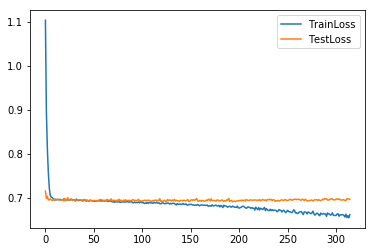

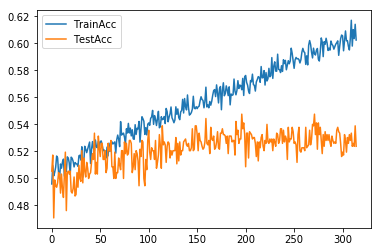

In [7]:
# Run (Train)

if __name__ == "__main__":

    model = get_model()

    reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=1e-6, verbose=0)
    e_stopping = EarlyStopping(patience=120)
    checkpoint = ModelCheckpoint(os.path.join('models', 'basic-classification.h5'), 
                                 monitor='val_acc', 
                                 verbose=0, 
                                 save_best_only=True)

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[reduce_LR, e_stopping, checkpoint])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
